# ML Synthetic Data Generation with Ray

This notebook demonstrates how to generate **synthetic data** for machine learning workflows
using spark-bestfit with **RayBackend** and **Ray Dataset**.

## What You'll Learn

1. **Load data** as Ray Dataset for distributed processing
2. **Fit distributions** using RayBackend's distributed aggregation
3. **Handle mixed types** (continuous + discrete columns)
4. **Use Gaussian Copula** to preserve correlations
5. **Generate synthetic data** at scale
6. **Validate** synthetic data quality

## Why Ray for Synthetic Data?

- **Distributed histogram computation** - no need to collect raw data
- **Parallel fitting** - fits ~90 distributions concurrently
- **Scalable generation** - generate millions of samples across workers
- **ML pipeline integration** - works with Ray Train, Ray Data, etc.

## Prerequisites

```bash
pip install spark-bestfit[ray] pandas numpy matplotlib scikit-learn
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ray

from spark_bestfit import (
    DistributionFitter, 
    DiscreteDistributionFitter,
    GaussianCopula,
    RayBackend
)

# Initialize Ray (auto-detects local resources)
if not ray.is_initialized():
    ray.init()

# Create RayBackend
backend = RayBackend()
print(f"RayBackend initialized with {backend.get_parallelism()} CPUs")

2026-01-04 15:44:32,485	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


RayBackend initialized with 10 CPUs


## Part 1: Create Sample "Production" Dataset as Ray Dataset

We'll simulate a customer dataset with mixed feature types:

- **Continuous**: age, income, account_balance, credit_score
- **Discrete**: num_products, num_transactions, tenure_months

In [2]:
np.random.seed(42)
n_customers = 10000  # Larger dataset for Ray

# Generate realistic customer data
data = {
    # Continuous features
    'age': np.clip(np.random.normal(42, 15, n_customers), 18, 85).astype(float),
    'income': np.random.lognormal(10.8, 0.6, n_customers),
    'account_balance': np.abs(np.random.normal(5000, 3000, n_customers)),
    'credit_score': np.clip(np.random.normal(700, 80, n_customers), 300, 850).astype(float),
    
    # Discrete features (as float for Ray Dataset compatibility)
    'num_products': np.random.poisson(2.5, n_customers).astype(float),
    'num_transactions': np.random.negative_binomial(5, 0.3, n_customers).astype(float),
    'tenure_months': np.random.geometric(0.02, n_customers).astype(float)
}

# Create pandas DataFrame first
original_pdf = pd.DataFrame(data)

# Convert to Ray Dataset for distributed processing
original_ds = ray.data.from_pandas(original_pdf)

print(f"Ray Dataset created: {original_ds.count()} customers")
print(f"Schema: {original_ds.schema()}")

Ray Dataset created: 10000 customers
Schema: Column            Type
------            ----
age               double
income            double
account_balance   double
credit_score      double
num_products      double
num_transactions  double
tenure_months     double


In [3]:
# Preview the data
original_ds.take(5)

2026-01-04 15:44:34,255	INFO dataset.py:3641 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2026-01-04 15:44:34,262	INFO logging.py:397 -- Registered dataset logger for dataset dataset_1_0
2026-01-04 15:44:34,267	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2026-01-04_15-44-30_183614_18541/logs/ray-data
2026-01-04 15:44:34,267	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> LimitOperator[limit=5]
2026-01-04 15:44:34,268	INFO streaming_executor.py:686 -- [dataset]: A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True` and `ray.data.DataContext.get_current().use_ray_tqdm = False`.
2026-01-04 15:44:34,268	INFO progress_bar.py:155 -- Progress bar disabled because stdout is a non-interactive terminal.
2026-01-04 15:44:34,270	WARNING resource_manager.py:13

[{'age': 49.45071229516849,
  'income': 32627.251760026287,
  'account_balance': 6044.858743000455,
  'credit_score': 541.5542425951675,
  'num_products': 3.0,
  'num_transactions': 33.0,
  'tenure_months': 15.0},
 {'age': 39.92603548243223,
  'income': 40810.73025120379,
  'account_balance': 5849.970777606999,
  'credit_score': 615.6011482450502,
  'num_products': 3.0,
  'num_transactions': 12.0,
  'tenure_months': 96.0},
 {'age': 51.715328071510385,
  'income': 34254.43633641738,
  'account_balance': 2190.4404625835264,
  'credit_score': 653.0377274965931,
  'num_products': 2.0,
  'num_transactions': 14.0,
  'tenure_months': 46.0},
 {'age': 64.84544784612038,
  'income': 52378.4658178188,
  'account_balance': 6738.752665291215,
  'credit_score': 711.9735128739753,
  'num_products': 3.0,
  'num_transactions': 18.0,
  'tenure_months': 31.0},
 {'age': 38.48769937914996,
  'income': 100539.61610187164,
  'account_balance': 529.7519732701456,
  'credit_score': 781.9329861285503,
  'num_pr

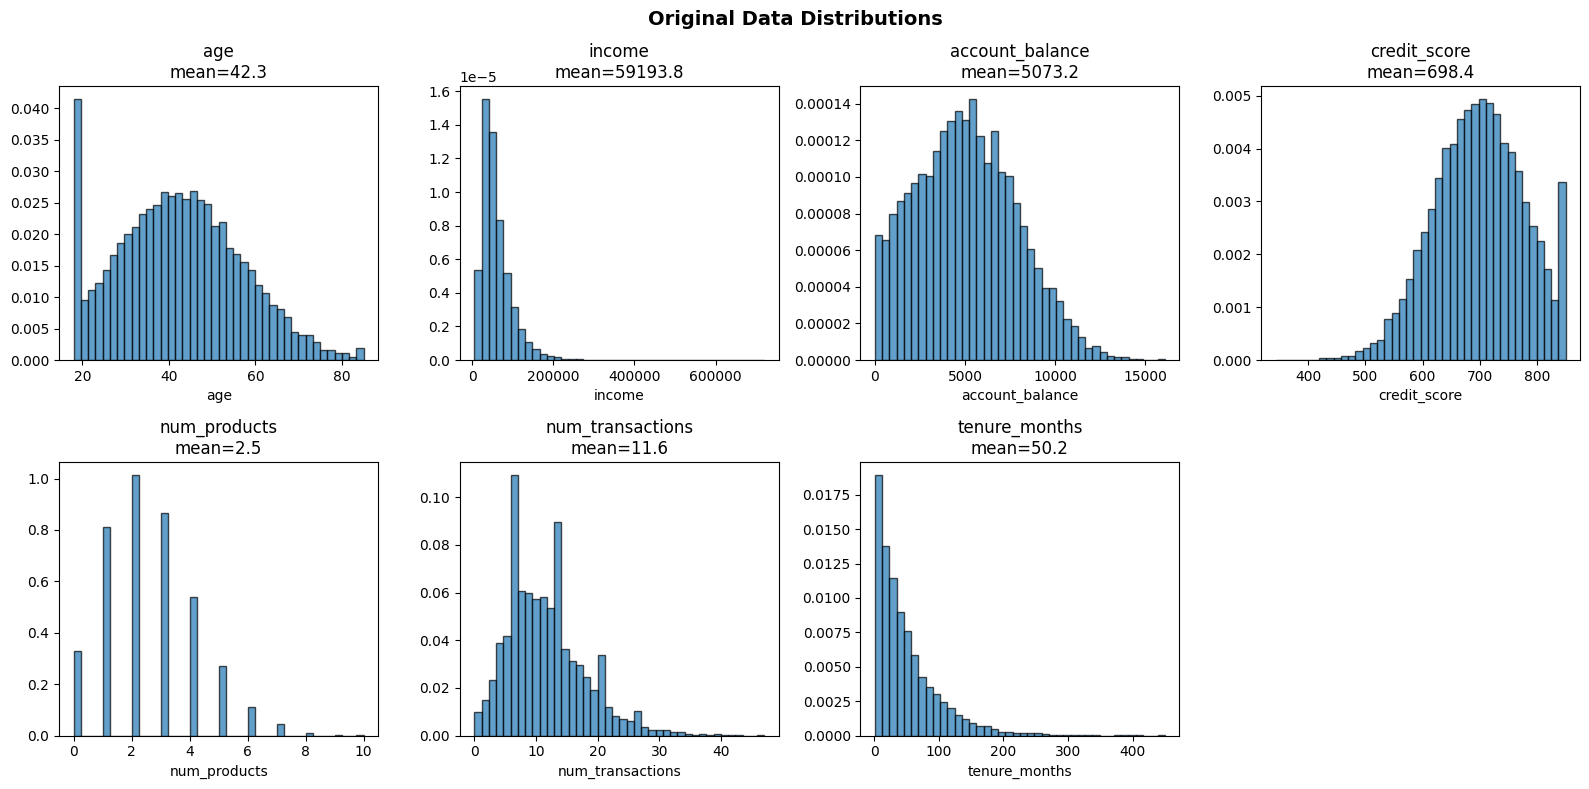

In [4]:
# Visualize original distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

columns = list(data.keys())
for i, col in enumerate(columns):
    if i < len(axes):
        axes[i].hist(original_pdf[col], bins=40, density=True, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}\nmean={original_pdf[col].mean():.1f}')
        axes[i].set_xlabel(col)

axes[-1].set_visible(False)

plt.suptitle('Original Data Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 2: Fit Distributions Using Ray Dataset

RayBackend computes histograms and statistics using distributed aggregation - no raw data collection needed.

In [5]:
# Define continuous and discrete columns
continuous_cols = ['age', 'income', 'account_balance', 'credit_score']
discrete_cols = ['num_products', 'num_transactions', 'tenure_months']

# Fit continuous distributions on Ray Dataset
cont_fitter = DistributionFitter(backend=backend)

# Note: Using lazy_metrics=False for Ray Dataset compatibility
# (lazy_metrics with Ray Dataset has a known limitation with resampling)
cont_results = cont_fitter.fit(
    original_ds,  # Ray Dataset input
    columns=continuous_cols,
    lazy_metrics=False,  # Compute metrics eagerly for Ray Dataset
    max_distributions=25
)

print(f"Fitted {cont_results.count()} continuous distribution-column combinations")

2026-01-04 15:44:34,618	INFO logging.py:397 -- Registered dataset logger for dataset dataset_4_0
2026-01-04 15:44:34,620	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_4_0. Full logs are in /tmp/ray/session_2026-01-04_15-44-30_183614_18541/logs/ray-data
2026-01-04 15:44:34,621	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_4_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-01-04 15:44:34,634	INFO progress_bar.py:213 -- === Ray Data Progress {Project} ===
2026-01-04 15:44:34,635	INFO progress_bar.py:215 -- Project: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 15:44:34,635	INFO progress_bar.py:213 -- === Ray Data Progress {HashAggregate(key_columns=(), num_partitions=1)} ===
2026-01-04 15:44:34,637	INFO progress_bar.py:215 -- Hash

Fitted 100 continuous distribution-column combinations


In [6]:
# Get best continuous fits
best_continuous = cont_results.best_per_column(n=1, metric='aic')

print("Best Continuous Distributions:\n")
for col, fits in best_continuous.items():
    fit = fits[0]
    print(f"  {col}: {fit.distribution} (AIC={fit.aic:.1f})")

Best Continuous Distributions:

  age: arcsine (AIC=70318.2)
  income: exponnorm (AIC=234424.5)
  account_balance: burr (AIC=186064.3)
  credit_score: beta (AIC=115408.1)


In [7]:
# Fit discrete distributions on Ray Dataset
disc_fitter = DiscreteDistributionFitter(backend=backend)

disc_results = disc_fitter.fit(
    original_ds,  # Ray Dataset input
    columns=discrete_cols
)

print(f"Fitted {disc_results.count()} discrete distribution-column combinations")

2026-01-04 15:44:41,427	INFO logging.py:397 -- Registered dataset logger for dataset dataset_43_0
2026-01-04 15:44:41,428	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_43_0. Full logs are in /tmp/ray/session_2026-01-04_15-44-30_183614_18541/logs/ray-data
2026-01-04 15:44:41,429	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_43_0: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(random_sample)->Project]
2026-01-04 15:44:41,434	INFO progress_bar.py:213 -- === Ray Data Progress {MapBatches(random_sample)->Project} ===
2026-01-04 15:44:41,434	INFO progress_bar.py:215 -- MapBatches(random_sample)->Project: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 15:44:41,435	INFO progress_bar.py:213 -- === Ray Data Progress {Running Dataset} ===
2026-01-04 15:44:41,435	INFO progress_bar.py:215 -- Running Dataset: dataset_43_0. Active & requested resources: 0/10 CPU, 0.0

Fitted 35 discrete distribution-column combinations


In [8]:
# Get best discrete fits
best_discrete = disc_results.best_per_column(n=1, metric='aic')

print("Best Discrete Distributions:\n")
for col, fits in best_discrete.items():
    fit = fits[0]
    print(f"  {col}: {fit.distribution} (AIC={fit.aic:.1f})")

Best Discrete Distributions:

  num_products: poisson (AIC=36657.1)
  num_transactions: nbinom (AIC=63478.3)
  tenure_months: geom (AIC=98114.2)


## Part 3: Capture Correlations with Gaussian Copula

Real data has correlations between features. The Gaussian Copula preserves these correlations
when generating synthetic data. RayBackend computes the correlation matrix using distributed
Pearson computation (no data collection).

In [9]:
# Fit copula on continuous columns using Ray Dataset
# This computes correlation via distributed sufficient statistics
copula = GaussianCopula.fit(
    cont_results,  # FitResults from continuous fitting
    original_ds,   # Ray Dataset for correlation computation
    backend=backend  # Use RayBackend for correlation
)

print("Correlation matrix (computed via distributed aggregation):")
corr_df = pd.DataFrame(
    copula.correlation_matrix,
    index=continuous_cols,
    columns=continuous_cols
)
print(corr_df.round(3))

2026-01-04 15:44:44,170	INFO logging.py:397 -- Registered dataset logger for dataset dataset_48_0
2026-01-04 15:44:44,171	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_48_0. Full logs are in /tmp/ray/session_2026-01-04_15-44-30_183614_18541/logs/ray-data
2026-01-04 15:44:44,172	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_48_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project]
2026-01-04 15:44:44,177	INFO progress_bar.py:213 -- === Ray Data Progress {Project} ===
2026-01-04 15:44:44,178	INFO progress_bar.py:215 -- Project: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 15:44:44,179	INFO progress_bar.py:213 -- === Ray Data Progress {Running Dataset} ===
2026-01-04 15:44:44,180	INFO progress_bar.py:215 -- Running Dataset: dataset_48_0. Active & requested resources: 0/10 CPU, 0.0B/1.0GiB object store: Progress Completed 0 / ?
2026-01-04 15:44:44,324	INFO stre

Correlation matrix (computed via distributed aggregation):
                   age  income  account_balance  credit_score
age              1.000  -0.007            0.019        -0.013
income          -0.007   1.000            0.031         0.008
account_balance  0.019   0.031            1.000         0.004
credit_score    -0.013   0.008            0.004         1.000


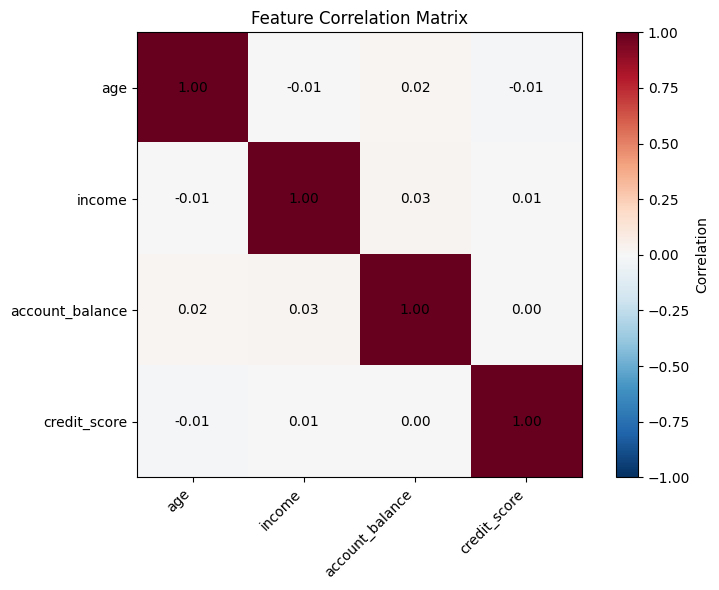

In [10]:
# Visualize correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(copula.correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(continuous_cols)), continuous_cols, rotation=45, ha='right')
plt.yticks(range(len(continuous_cols)), continuous_cols)
plt.title('Feature Correlation Matrix')

# Add correlation values
for i in range(len(continuous_cols)):
    for j in range(len(continuous_cols)):
        plt.text(j, i, f'{copula.correlation_matrix[i, j]:.2f}',
                 ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Part 4: Generate Synthetic Data

Generate synthetic data that preserves both marginal distributions and correlations.

In [11]:
# Generate correlated continuous features via copula
print("Generating correlated continuous features...")
continuous_samples = copula.sample(n=n_customers, random_state=42)

# Generate independent discrete features
print("Generating discrete features...")
discrete_samples = {}
for col, fits in best_discrete.items():
    fit = fits[0]
    discrete_samples[col] = fit.sample(size=n_customers)

# Combine into synthetic dataset
synthetic_pdf = pd.DataFrame(continuous_samples)
for col, samples in discrete_samples.items():
    synthetic_pdf[col] = samples

print(f"\nGenerated {len(synthetic_pdf)} synthetic records")
synthetic_pdf.head()

Generating correlated continuous features...
Generating discrete features...

Generated 10000 synthetic records


,age,income,account_balance,credit_score,num_products,num_transactions,tenure_months
0,32.489669,111849.729968,2994.914077,718.603778,2,16,117
1,21.603291,26461.788373,1059.619976,730.712123,4,10,26
2,31.736080,92927.900712,2692.559575,695.506189,0,13,123
3,44.862078,35027.456087,7331.634093,607.146679,4,5,47
4,27.176899,82416.146496,5225.690915,699.645637,3,11,46


In [12]:
# Convert synthetic data to Ray Dataset for further processing
synthetic_ds = ray.data.from_pandas(synthetic_pdf)
print(f"Synthetic Ray Dataset: {synthetic_ds.count()} rows")

Synthetic Ray Dataset: 10000 rows


## Part 5: Validate Synthetic Data Quality

Compare synthetic data to original using statistical tests.

In [13]:
# Compare summary statistics
all_cols = continuous_cols + discrete_cols

comparison = pd.DataFrame({
    'Original Mean': original_pdf[all_cols].mean(),
    'Synthetic Mean': synthetic_pdf[all_cols].mean(),
    'Original Std': original_pdf[all_cols].std(),
    'Synthetic Std': synthetic_pdf[all_cols].std(),
})

comparison['Mean Diff %'] = ((comparison['Synthetic Mean'] - comparison['Original Mean']) 
                              / comparison['Original Mean'] * 100).round(1)
comparison['Std Diff %'] = ((comparison['Synthetic Std'] - comparison['Original Std']) 
                             / comparison['Original Std'] * 100).round(1)

print("Statistical Comparison:\n")
print(comparison.round(2).to_string())

Statistical Comparison:

                  Original Mean  Synthetic Mean  Original Std  Synthetic Std  Mean Diff %  Std Diff %
age                       42.32           42.60         14.29          14.51          0.7         1.6
income                 59193.84        59025.57      39307.18       38430.12         -0.3        -2.2
account_balance         5073.22         5088.54       2781.37        2830.82          0.3         1.8
credit_score             698.43          697.79         78.20          79.01         -0.1         1.0
num_products               2.51            2.52          1.58           1.59          0.5         0.3
num_transactions          11.61           11.55          6.25           6.17         -0.5        -1.2
tenure_months             50.18           49.95         49.21          49.35         -0.5         0.3


In [14]:
# Compare correlation preservation
print("Correlation Preservation (Continuous Features):\n")

original_corr = original_pdf[continuous_cols].corr()
synthetic_corr = synthetic_pdf[continuous_cols].corr()

print("Original Correlation:")
print(original_corr.round(3))
print("\nSynthetic Correlation:")
print(synthetic_corr.round(3))
print("\nCorrelation Difference (should be close to 0):")
print((synthetic_corr - original_corr).round(3))

Correlation Preservation (Continuous Features):

Original Correlation:
                   age  income  account_balance  credit_score
age              1.000  -0.007            0.020        -0.011
income          -0.007   1.000            0.034         0.011
account_balance  0.020   0.034            1.000         0.002
credit_score    -0.011   0.011            0.002         1.000

Synthetic Correlation:
                   age  income  account_balance  credit_score
age              1.000  -0.000            0.010        -0.019
income          -0.000   1.000            0.012         0.007
account_balance  0.010   0.012            1.000        -0.020
credit_score    -0.019   0.007           -0.020         1.000

Correlation Difference (should be close to 0):
                   age  income  account_balance  credit_score
age              0.000   0.007           -0.010        -0.008
income           0.007   0.000           -0.021        -0.004
account_balance -0.010  -0.021            0.000    

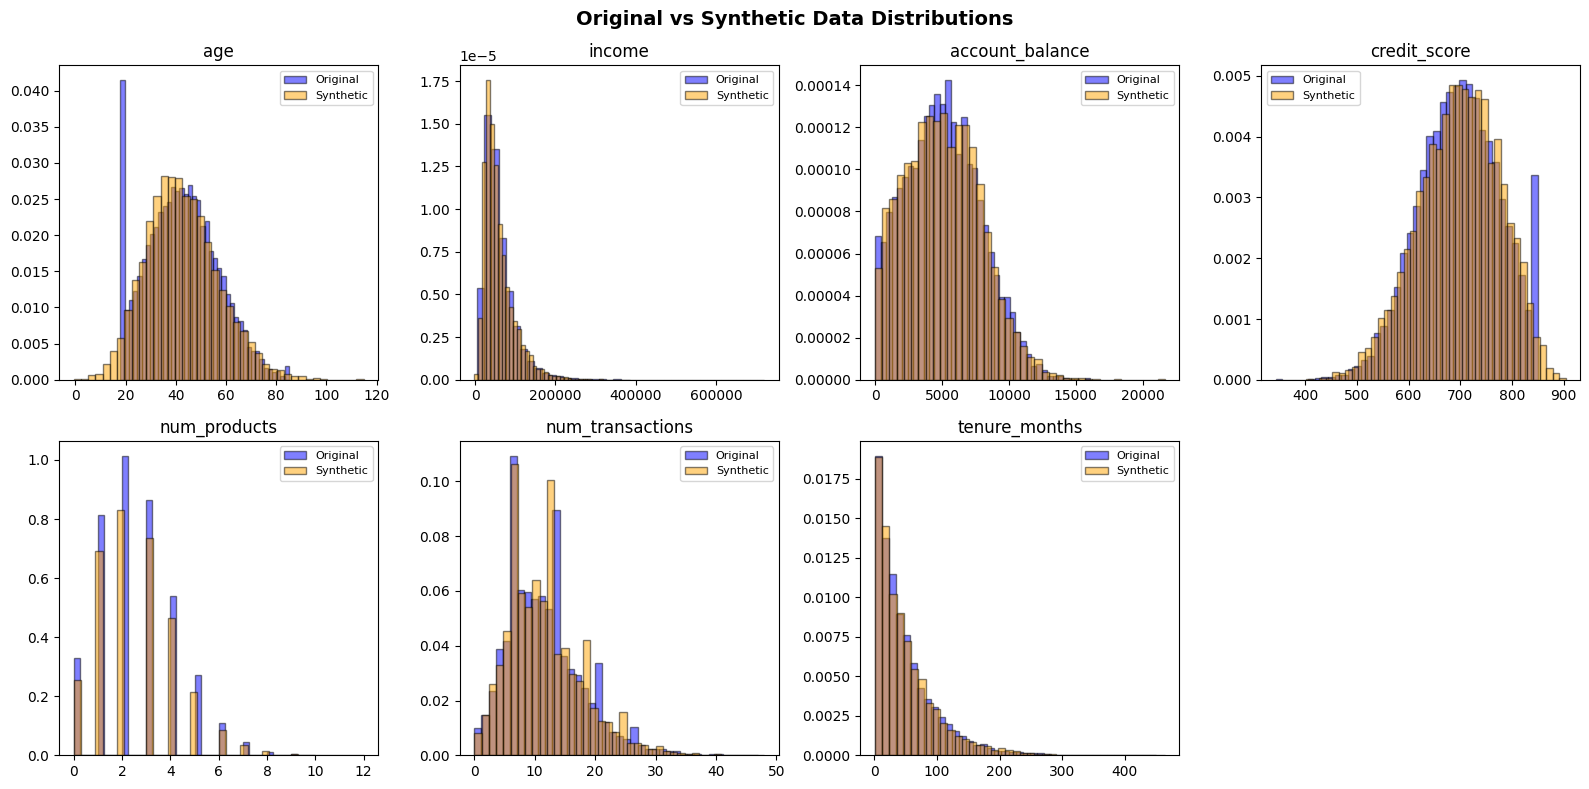

In [15]:
# Visual comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    if i < len(axes):
        axes[i].hist(original_pdf[col], bins=40, density=True, alpha=0.5, 
                     label='Original', color='blue', edgecolor='black')
        axes[i].hist(synthetic_pdf[col], bins=40, density=True, alpha=0.5,
                     label='Synthetic', color='orange', edgecolor='black')
        axes[i].set_title(col)
        axes[i].legend(fontsize=8)

axes[-1].set_visible(False)

plt.suptitle('Original vs Synthetic Data Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Kolmogorov-Smirnov test for distribution similarity
from scipy import stats

print("Kolmogorov-Smirnov Tests (Original vs Synthetic):\n")
print(f"{'Column':<20} {'KS Statistic':<15} {'p-value':<15} {'Match?'}")
print("-" * 60)

for col in all_cols:
    ks_stat, p_value = stats.ks_2samp(original_pdf[col], synthetic_pdf[col])
    match = "Yes" if p_value > 0.05 else "No"
    print(f"{col:<20} {ks_stat:<15.4f} {p_value:<15.4f} {match}")

print("\n(p-value > 0.05 suggests distributions are similar)")

Kolmogorov-Smirnov Tests (Original vs Synthetic):

Column               KS Statistic    p-value         Match?
------------------------------------------------------------
age                  0.0327          0.0000          No
income               0.0203          0.0325          No
account_balance      0.0151          0.2043          Yes
credit_score         0.0202          0.0338          No
num_products         0.0055          0.9982          Yes
num_transactions     0.0087          0.8436          Yes
tenure_months        0.0140          0.2809          Yes

(p-value > 0.05 suggests distributions are similar)


## Part 6: Scale Up - Generate Large Synthetic Dataset

Use RayBackend's distributed sample generation for large-scale synthetic data.

In [17]:
# Generate 100K samples using distributed generation
n_large = 100000

print(f"Generating {n_large:,} synthetic records using distributed generation...")

# Continuous features via copula
large_continuous = copula.sample(n=n_large, random_state=123)

# Discrete features via distributed generation
large_discrete = {}
for col, fits in best_discrete.items():
    fit = fits[0]
    
    def make_generator(frozen_dist):
        def generator_func(n_samples, partition_id, seed):
            np.random.seed(seed)
            return {col: frozen_dist.rvs(size=n_samples)}
        return generator_func
    
    samples_df = backend.generate_samples(
        n=n_large,
        generator_func=make_generator(fit.get_scipy_dist()),
        column_names=[col],
        num_partitions=4,
        random_seed=123
    )
    large_discrete[col] = samples_df[col].values

# Combine
large_synthetic = pd.DataFrame(large_continuous)
for col, samples in large_discrete.items():
    large_synthetic[col] = samples

print(f"Generated {len(large_synthetic):,} synthetic records")
print(f"\nSummary statistics:")
print(large_synthetic.describe().round(2))

Generating 100,000 synthetic records using distributed generation...
Generated 100,000 synthetic records

Summary statistics:
             age     income  account_balance  credit_score  num_products  \
count  100000.00  100000.00        100000.00     100000.00     100000.00   
mean       42.31   59228.15          5086.92        698.70          2.50   
std        14.32   38582.85          2832.45         78.79          1.58   
min        -7.14   -8708.76           -37.89        388.89          0.00   
25%        32.22   32801.25          2871.63        645.11          1.00   
50%        41.30   48527.69          4991.82        702.82          2.00   
75%        51.35   74653.86          7060.44        756.47          3.00   
max       117.91  440647.17         25773.49        909.51         11.00   

       num_transactions  tenure_months  
count         100000.00      100000.00  
mean              11.61          49.97  
std                6.22          49.56  
min                0.00  

In [18]:
# Convert to Ray Dataset for downstream ML pipelines
large_synthetic_ds = ray.data.from_pandas(large_synthetic)
print(f"Large synthetic Ray Dataset: {large_synthetic_ds.count():,} rows")
print(f"Schema: {large_synthetic_ds.schema()}")

Large synthetic Ray Dataset: 100,000 rows
Schema: Column            Type
------            ----
age               double
income            double
account_balance   double
credit_score      double
num_products      int64
num_transactions  int64
tenure_months     int64


## Part 7: ML Validation - Train on Synthetic, Test on Real

Validate synthetic data quality by training a model on synthetic data and testing on real data.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create binary target (high-value customer: income > median)
median_income = original_pdf['income'].median()

original_pdf['high_value'] = (original_pdf['income'] > median_income).astype(int)
synthetic_pdf['high_value'] = (synthetic_pdf['income'] > median_income).astype(int)

# Features (exclude income since it defines the target)
feature_cols = ['age', 'account_balance', 'credit_score', 
                'num_products', 'num_transactions', 'tenure_months']

# Split original data for testing
X_original = original_pdf[feature_cols]
y_original = original_pdf['high_value']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42
)

# Synthetic training data
X_synthetic = synthetic_pdf[feature_cols]
y_synthetic = synthetic_pdf['high_value']

print(f"Training (original): {len(X_train_orig)} samples")
print(f"Training (synthetic): {len(X_synthetic)} samples")
print(f"Test set (real): {len(X_test)} samples")

Training (original): 7000 samples
Training (synthetic): 10000 samples
Test set (real): 3000 samples


In [20]:
# Model 1: Train on original, test on real
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train_orig, y_train_orig)
acc_original = accuracy_score(y_test, rf_original.predict(X_test))

# Model 2: Train on synthetic, test on real
rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_synthetic.fit(X_synthetic, y_synthetic)
acc_synthetic = accuracy_score(y_test, rf_synthetic.predict(X_test))

print("Model Performance on Real Test Data:\n")
print(f"  Trained on Original:  {acc_original:.1%} accuracy")
print(f"  Trained on Synthetic: {acc_synthetic:.1%} accuracy")
print(f"\n  Difference: {abs(acc_original - acc_synthetic):.1%}")

if abs(acc_original - acc_synthetic) < 0.05:
    print("\n  Synthetic data achieves similar model performance!")

Model Performance on Real Test Data:

  Trained on Original:  49.7% accuracy
  Trained on Synthetic: 49.3% accuracy

  Difference: 0.4%

  Synthetic data achieves similar model performance!


## Summary

This notebook demonstrated synthetic data generation using **RayBackend** and **Ray Dataset**:

### Workflow

1. **Load data as Ray Dataset** - distributed from the start
2. **Fit distributions** - histograms computed via distributed aggregation
3. **Capture correlations** - Gaussian Copula with distributed Pearson computation
4. **Generate synthetic data** - preserves marginals and correlations
5. **Scale up** - generate 100K+ samples using distributed generation
6. **Validate** - synthetic-trained models achieve similar accuracy

### Key RayBackend Advantages

| Feature | Benefit |
|---------|--------|
| Distributed histograms | No raw data collection |
| Distributed correlation | Sufficient statistics, not data |
| Parallel fitting | ~90 distributions concurrently |
| Distributed generation | Scale to millions of samples |
| Ray Dataset support | Seamless ML pipeline integration |

### When to Use Ray for Synthetic Data

- Data already in Ray ecosystem
- Need to generate millions of samples
- Part of Ray Train/Tune pipeline
- No Spark cluster available

In [21]:
# Cleanup (optional)
ray.shutdown()